### `Import the main libraries`

In [109]:
## major
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os , joblib , missingno

## sklearn 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression , SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## XGGOOST
from xgboost import XGBRegressor

### `Load the data and look at the big picture`

In [2]:
## read csv file
file_path = os.path.join(os.getcwd(),'housing.csv')
df = pd.read_csv(file_path)


## show the head
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
## check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
## some statistics
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
## check null values
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### `Exploratory Data Analysis (EDA)`

categories of (ocean_proximity) --- 
 ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


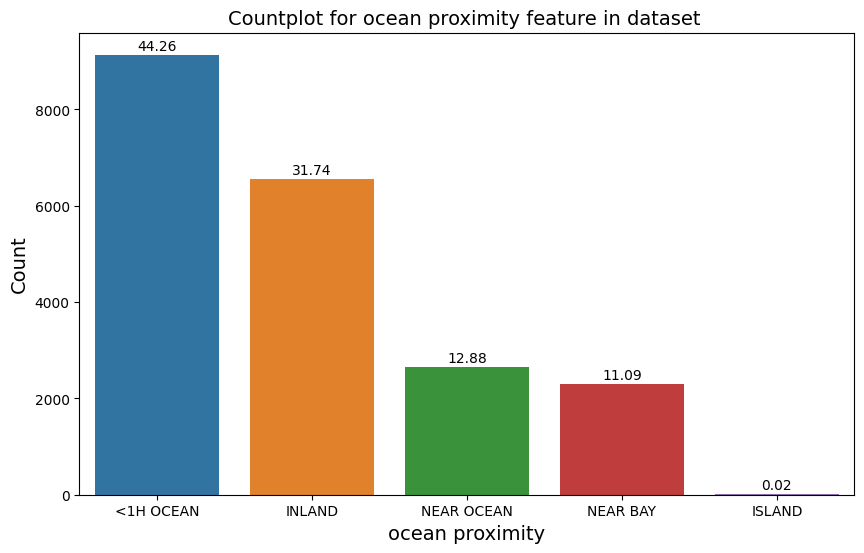

In [7]:
## Check the Distribution of (ocean_proximity) Feature in Dataset
ocean_val = df['ocean_proximity'].value_counts()
print('categories of (ocean_proximity) --- \n', ocean_val)

## plotting it 
plt.figure(figsize=(10,6))
sns.countplot(x = 'ocean_proximity',data = df , order = ocean_val.index)
plt.title('Countplot for ocean proximity feature in dataset ',fontsize = 14)
plt.xlabel('ocean proximity',fontsize = 14)
plt.ylabel('Count',fontsize = 14)


## show the percentage
for i in range(len(ocean_val)):
    value = ocean_val[i]
    string = f'{((value*100) / len(df)).round(2)}'
    plt.text(x = i , y = value +100 , s = string ,ha = 'center' )
    
    
plt.show()

In [8]:
## replace <1H OCEAN to 1H OCEAN -- will cause an error in deployment
df['ocean_proximity'].replace('<1H OCEAN','1H OCEAN',inplace = True)

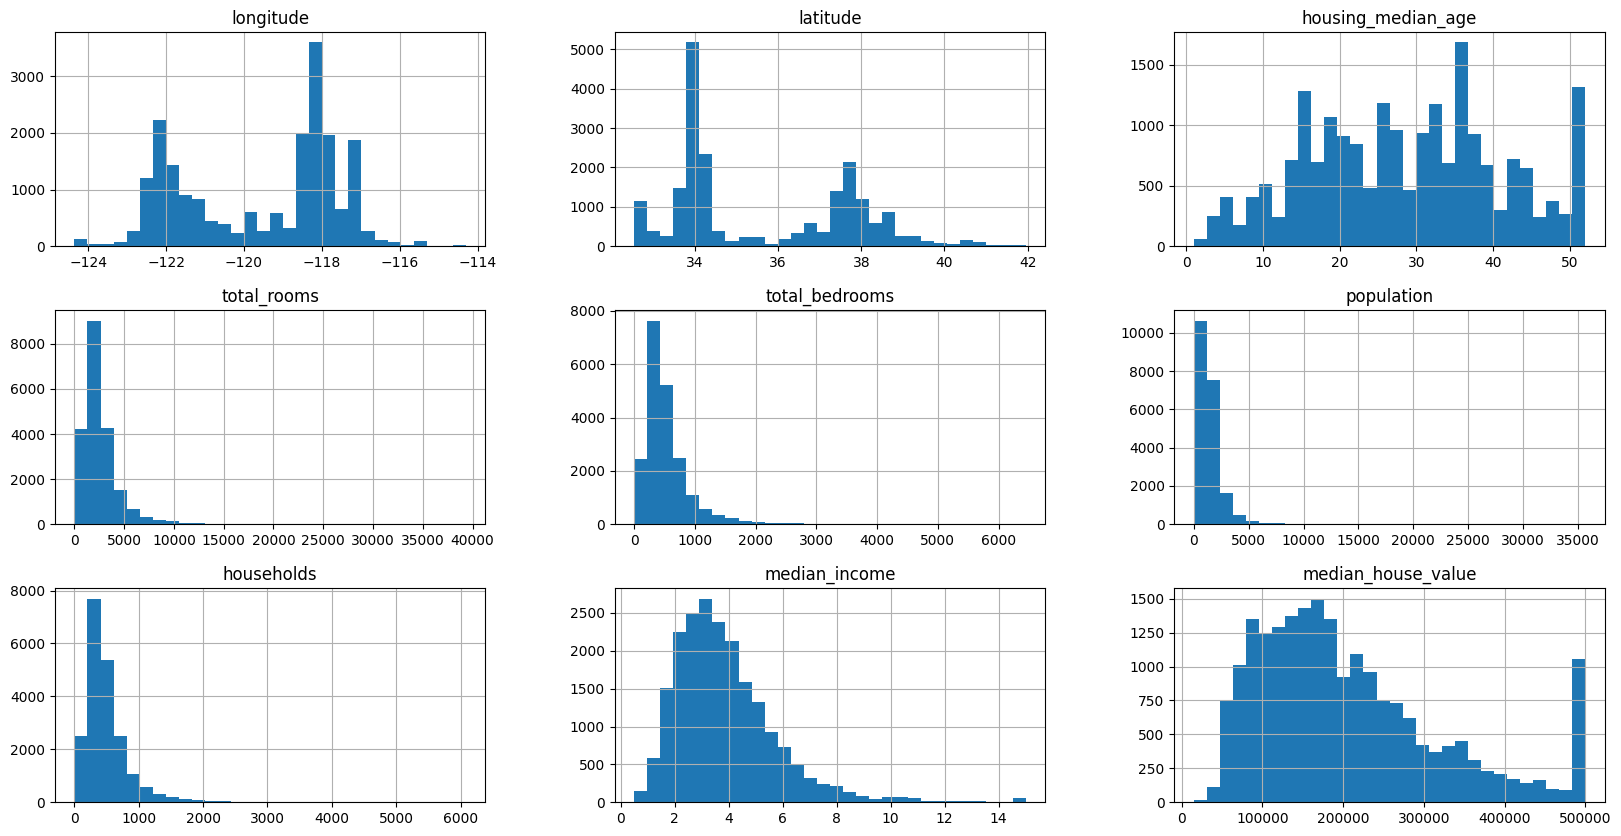

In [9]:
## Histogram Distribution of Numerical Variables in Dataset
df.hist(bins= 30 , figsize=(20,10))
plt.show()

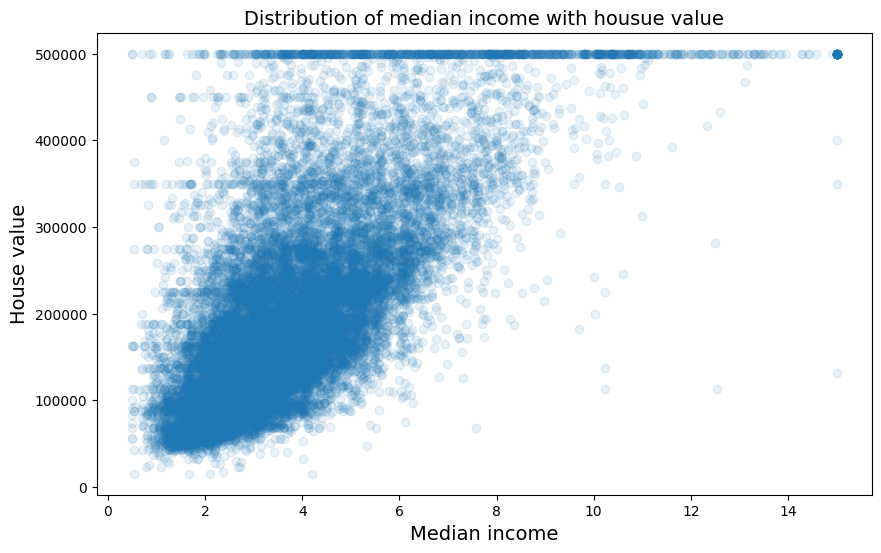

In [10]:
## scatterplot with median income and house value
plt.figure(figsize=(10,6))
plt.scatter(x = df['median_income'], y = df['median_house_value'],alpha = 0.1)
plt.title('Distribution of median income with housue value',fontsize = 14)
plt.xlabel('Median income',fontsize = 14)
plt.ylabel('House value',fontsize = 14)
plt.show()

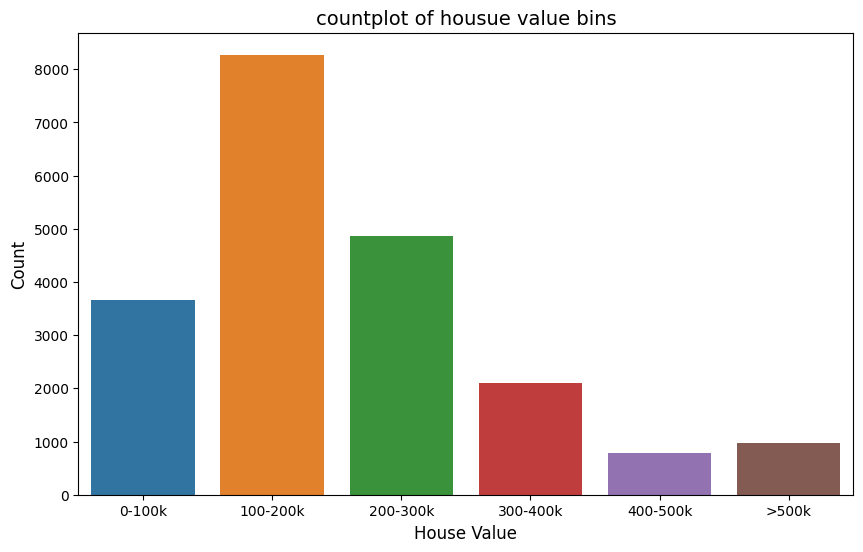

In [12]:
## convert values of house values to bins

house_val_bins = pd.cut(x = df['median_house_value'],bins=[-np.inf , 100000 , 200000 , 300000 , 400000 ,500000, np.inf],
       labels=['0-100k','100-200k','200-300k','300-400k','400-500k','>500k'])

plt.figure(figsize=(10,6))
sns.countplot(x = house_val_bins )
plt.title('countplot of housue value bins',fontsize = 14)
plt.xlabel('House Value',fontsize = 12)
plt.ylabel('Count',fontsize = 12)
plt.show()

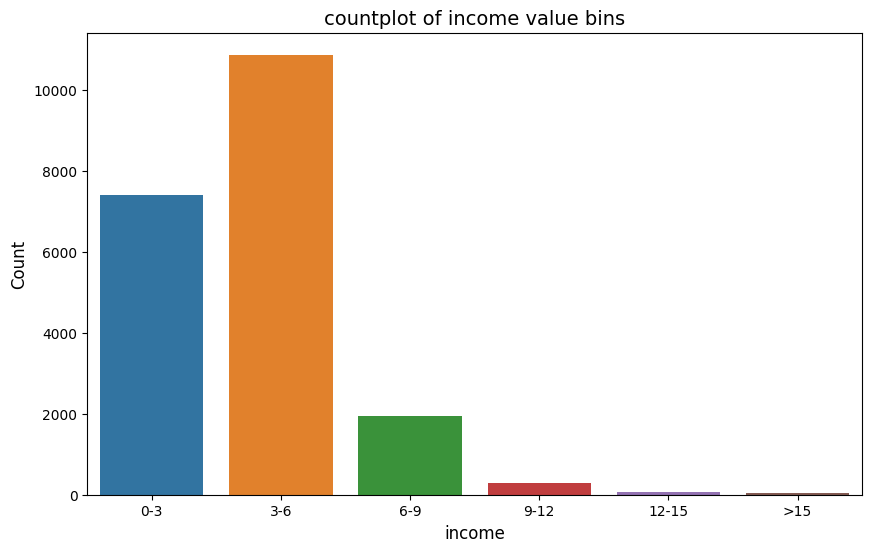

In [14]:
## convert values of income to bins

income_val_bins = pd.cut(x = df['median_income'],bins=[-np.inf , 3 , 6 , 9 , 12 ,15, np.inf],
       labels=['0-3','3-6','6-9','9-12','12-15','>15'])

plt.figure(figsize=(10,6))
sns.countplot(x = income_val_bins )
plt.title('countplot of income value bins',fontsize = 14)
plt.xlabel('income',fontsize = 12)
plt.ylabel('Count',fontsize = 12)
plt.show()

### `Check the correlation between the features and target  `

In [15]:
## using person corrleation
df.loc[: , df.columns != 'ocean_proximity'].corr()['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

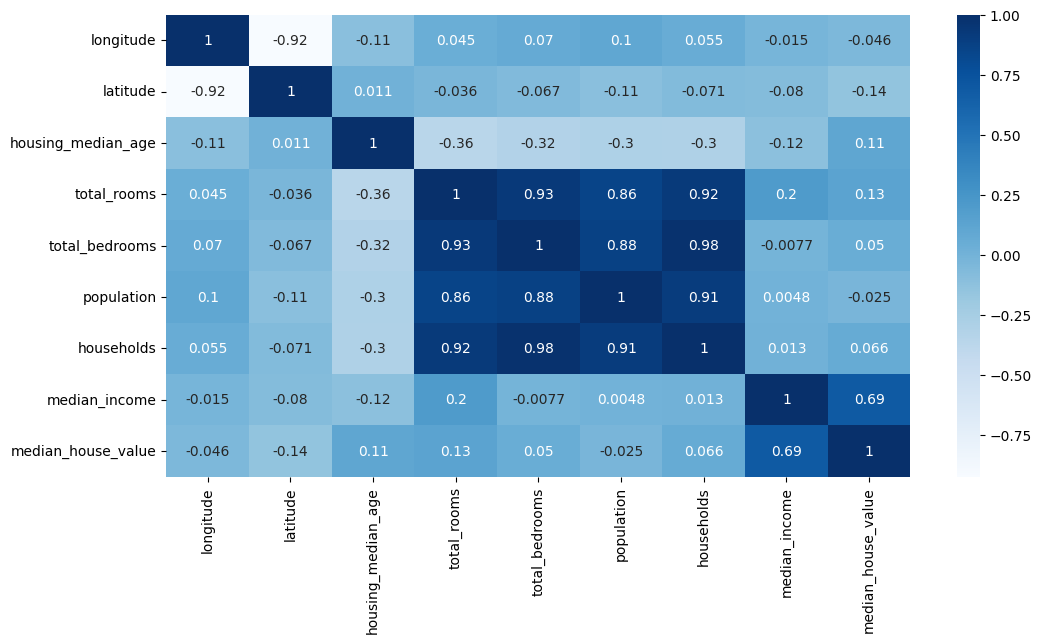

In [16]:
## you can show this as heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.loc[: , df.columns != 'ocean_proximity'].corr(), annot=True , cmap= 'Blues')
plt.show()

.`Comment : It seems the most corrleated feature with our target is 'Median_income' `.

### `Feature Engenieering`

`Tring to make some features , thinking that it will be more correlated to the target `

In [17]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bed_rooms_per_rooms'] = df['total_bedrooms'] / df['total_rooms']


In [18]:
## check correlation again
df.loc[: , df.columns != 'ocean_proximity'].corr()['median_house_value'].sort_values(ascending = False)

median_house_value     1.000000
median_income          0.688075
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
population            -0.024650
longitude             -0.045967
latitude              -0.144160
bed_rooms_per_rooms   -0.255880
Name: median_house_value, dtype: float64

### `Split The Dataset`

In [19]:
## Split data to features and target
X = df.drop('median_house_value',axis = 1)
Y = df['median_house_value']

In [20]:
## Split data to train and test
X_train , X_test , Y_train , Y_test = train_test_split(X,Y , test_size= 0.2 , random_state=42)

In [21]:
## check shapes
print(f'X_train shape is {X_train.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'Y_train shape is {Y_train.shape}')
print(f'Y_test shape is {Y_test.shape}')

X_train shape is (16512, 11)
X_test shape is (4128, 11)
Y_train shape is (16512,)
Y_test shape is (4128,)


### `Create a pipline to make Preprocessing`

In [22]:
## separate columns according to type
cat_columns = X.select_dtypes(include=['object']).columns.tolist()
num_columns = X.select_dtypes(include=['float64']).columns.tolist()

In [23]:
## pipline for numerical features
num_pipline = Pipeline(steps= [
                        ('selector', DataFrameSelector(num_columns)),
                        ('imputer', SimpleImputer(strategy= 'median')),
                        ('scaler', StandardScaler())
                    ])

## pipline for categorical feature
cat_pipline = Pipeline(steps=[
                        ('selector', DataFrameSelector(cat_columns)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('ohe', OneHotEncoder(sparse= False))
                    ])

## get all together
total_pipline = FeatureUnion(transformer_list=[
                        ('num', num_pipline),
                        ('categ', cat_pipline)
                    ])


## apply total pipline
X_train_final = total_pipline.fit_transform(X_train)
X_test_final = total_pipline.transform(X_test)

C:\Users\Mohamed Swalem\anaconda3\envs\HousingPrice\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### `Building Models`

`Evaluation metric is RMSE`

In [61]:
## Define function to train models
def train(model, model_name):
    model.fit(X_train_final, Y_train)
    y_train_pred= model.predict(X_train_final)
    rmse= np.sqrt(mean_squared_error(Y_train, y_train_pred))
    model_score_train= model.score(X_train_final, Y_train)
    model_score_test= model.score(X_test_final, Y_test)
    print(f'{model_name} Root Mean Squared Error is {rmse}')
    print(f'{model_name} Score in traininig data is {model_score_train}')
    print(f'{model_name} Score in testng data is {model_score_test}')


## define function to make cross validation    
def kfolds(model, model_name):
    rmse = np.sqrt(cross_val_score(model, X_train_final, Y_train, cv= 5, scoring= 'neg_mean_squared_error').mean()*-1)
    scores = cross_val_score(model, X_train_final, Y_train, cv= 5)
    model_score= np.average(scores)
    print(f'{model_name} Root Mean Squared Error is {rmse}')
    print(f'{model_name} Score is {model_score}')


`Random Forest`

In [69]:
RF = RandomForestRegressor(n_estimators= 150, max_depth= 6, max_samples= 0.8 ,random_state= 42)

In [70]:
train(RF, 'Random Forest')

Random Forest Root Mean Squared Error is 61698.04239778925
Random Forest Score in traininig data is 0.715237097511952
Random Forest Score in testng data is 0.6772386945760838


In [67]:
kfolds(RF, 'Random Forest' )

Random Forest Root Mean Squared Error is 63950.81773832979
Random Forest Score is 0.6939831351168276


`Tunning Random Forest`

In [89]:
params_best_forest = {
    'n_estimators': np.arange(100,300,50),
    'max_depth': [2,4,6,8,10,12],
    'max_samples': [0.6,0.7,0.8,0.9]
}


random_search =RandomizedSearchCV(estimator= RF, param_distributions= params_best_forest, n_iter= 20, random_state= 42,
                   scoring= 'neg_mean_squared_error', cv= 5, verbose=2)



In [91]:
random_search.fit(X_train_final, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ....max_depth=12, max_samples=0.6, n_estimators=100; total time=  43.9s
[CV] END ....max_depth=12, max_samples=0.6, n_estimators=100; total time=  42.4s
[CV] END ....max_depth=12, max_samples=0.6, n_estimators=100; total time=  44.1s
[CV] END ....max_depth=12, max_samples=0.6, n_estimators=100; total time=  43.7s
[CV] END ....max_depth=12, max_samples=0.6, n_estimators=100; total time=  43.8s
[CV] END ....max_depth=10, max_samples=0.9, n_estimators=150; total time= 1.1min
[CV] END ....max_depth=10, max_samples=0.9, n_estimators=150; total time= 1.2min
[CV] END ....max_depth=10, max_samples=0.9, n_estimators=150; total time= 1.1min
[CV] END ....max_depth=10, max_samples=0.9, n_estimators=150; total time= 1.1min
[CV] END ....max_depth=10, max_samples=0.9, n_estimators=150; total time= 1.0min
[CV] END ....max_depth=10, max_samples=0.8, n_estimators=150; total time=  26.1s
[CV] END ....max_depth=10, max_samples=0.8, n_e

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=6, max_samples=0.8,
                                                   n_estimators=150,
                                                   random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12],
                                        'max_samples': [0.6, 0.7, 0.8, 0.9],
                                        'n_estimators': array([100, 150, 200, 250])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [92]:
random_search.best_params_

{'n_estimators': 200, 'max_samples': 0.9, 'max_depth': 12}

In [95]:
best_forest= random_search.best_estimator_

RandomForestRegressor(max_depth=12, max_samples=0.9, n_estimators=200,
                      random_state=42)

In [111]:
train(best_forest , 'random')

random Root Mean Squared Error is 35603.725296360964
random Score in traininig data is 0.9051731062191779
random Score in testng data is 0.7960411071852969


In [112]:
kfolds(best_forest , "Random Forest")

KeyboardInterrupt: 

`Xgboost`

In [113]:
xgb= XGBRegressor(n_estimators=100 ,max_depth= 6, learning_rate= 0.1, subsample= 0.8)

In [114]:
train(xgb , 'XGBosst')

XGBosst Root Mean Squared Error is 38128.61016420159
XGBosst Score in traininig data is 0.8912466630416129
XGBosst Score in testng data is 0.819319064333288


In [118]:
params_best_XGB = {
    'n_estimators': np.arange(100,200,50),
    'max_depth': np.arange(4,15,2),
    'learning_rate': [0.1,0.2],
    'subsample': [0.8,0.9]
}


grid_xgb= GridSearchCV(estimator=xgb, param_grid= params_best_XGB, cv= 5, n_jobs= -1,
             verbose= 6, scoring='neg_mean_squared_error')
#grid_xgb.fit(X_train_final,Y_train)

In [119]:
train(grid_xgb, 'xgb')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

In [121]:
best_xgb= XGBRegressor(n_estimators=150 ,max_depth= 8, learning_rate= 0.1, subsample= 0.8)
train(best_xgb,'XGB')

XGB Root Mean Squared Error is 22873.97328514317
XGB Score in traininig data is 0.9608597260760963
XGB Score in testng data is 0.8382515617041082


### `Download the best model`

In [ ]:
jobliblib.dump(best_xgb, 'model_housingPrice_XGB.pkl')